In [18]:
# Step 1: Import libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set(style="whitegrid")


In [19]:
# Step 2: Load dataset
df = pd.read_excel("Online Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [20]:
# Step 3: Data Cleaning
df = df.dropna(subset=['CustomerID'])   # drop missing customers
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # remove cancelled orders
df = df[df['Quantity'] > 0]  # keep only positive quantities

df['order_value'] = df['Quantity'] * df['UnitPrice']  # new column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [21]:
# Step 4: Save cleaned data
df.to_csv("orders_clean.csv", index=False)


In [22]:
# Step 5: Load into SQLite database
conn = sqlite3.connect("retail.db")
df.to_sql("orders", conn, if_exists="replace", index=False)


397924

In [23]:
# Step 6: SQL Queries

# Total revenue
query1 = "SELECT SUM(order_value) as total_revenue FROM orders;"
print(pd.read_sql(query1, conn))

# Monthly revenue
query2 = """
SELECT strftime('%Y-%m', InvoiceDate) AS month, SUM(order_value) as revenue
FROM orders GROUP BY month ORDER BY month;
"""
monthly_sql = pd.read_sql(query2, conn)
print(monthly_sql.head())

# Top 5 customers
query3 = """
SELECT CustomerID, SUM(order_value) AS revenue
FROM orders GROUP BY CustomerID ORDER BY revenue DESC LIMIT 5;
"""
top_customers_sql = pd.read_sql(query3, conn)
print(top_customers_sql)

# Top 5 products
query4 = """
SELECT Description, SUM(order_value) AS revenue
FROM orders GROUP BY Description ORDER BY revenue DESC LIMIT 5;
"""
top_products_sql = pd.read_sql(query4, conn)
print(top_products_sql)


   total_revenue
0    8911407.904
     month     revenue
0  2010-12  572713.890
1  2011-01  569445.040
2  2011-02  447137.350
3  2011-03  595500.760
4  2011-04  469200.361
   CustomerID    revenue
0     14646.0  280206.02
1     18102.0  259657.30
2     17450.0  194550.79
3     16446.0  168472.50
4     14911.0  143825.06
                          Description    revenue
0         PAPER CRAFT , LITTLE BIRDIE  168469.60
1            REGENCY CAKESTAND 3 TIER  142592.95
2  WHITE HANGING HEART T-LIGHT HOLDER  100448.15
3             JUMBO BAG RED RETROSPOT   85220.78
4      MEDIUM CERAMIC TOP STORAGE JAR   81416.73


In [24]:
# Step 7: RFM Analysis
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'order_value': 'sum'
}).reset_index()

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


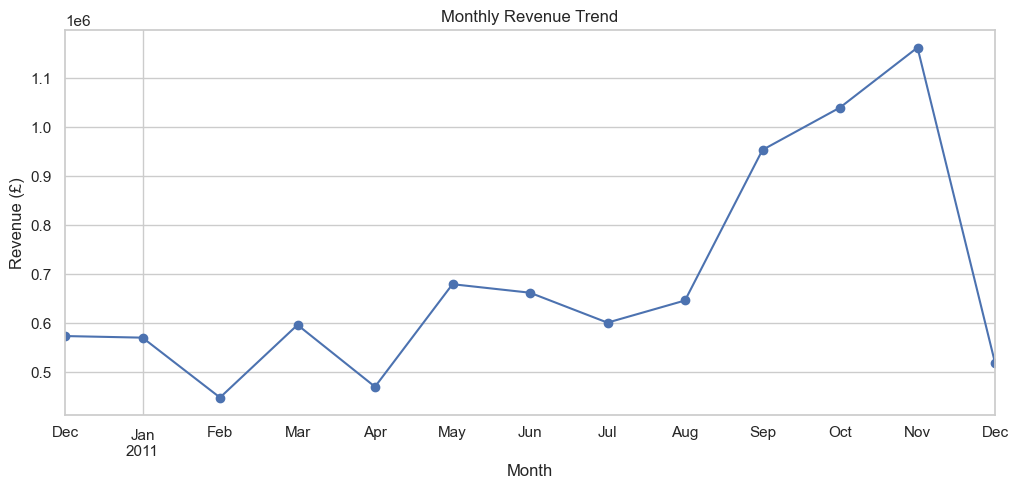

In [25]:
# Step 8: Visualizations

# 8.1 Monthly revenue trend
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly = df.groupby('Month')['order_value'].sum()

plt.figure(figsize=(12,5))
monthly.plot(kind='line', marker='o', title='Monthly Revenue Trend')
plt.ylabel("Revenue (£)")
plt.xlabel("Month")
plt.show()


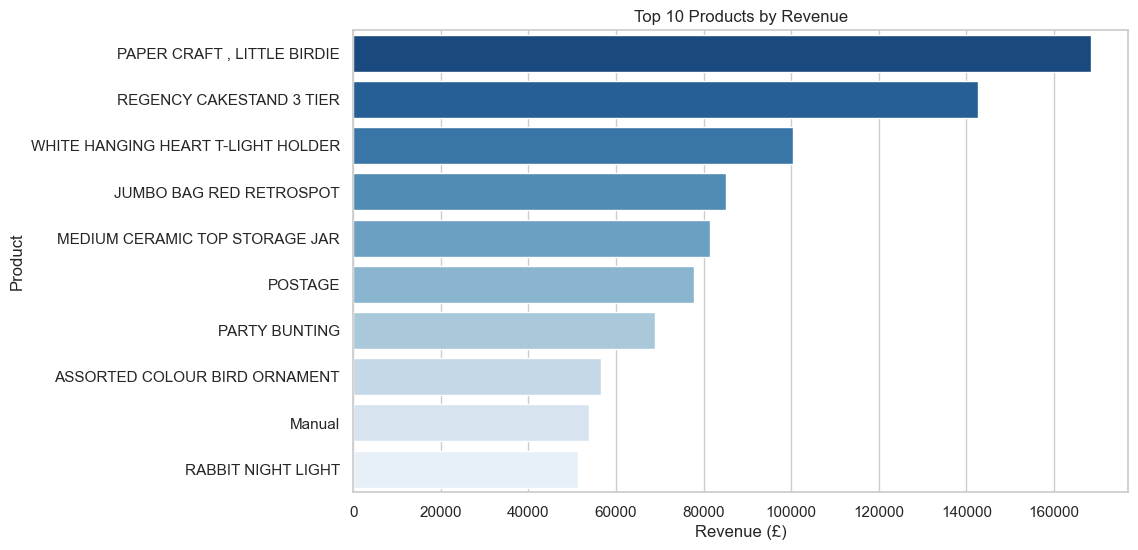

In [30]:
# 8.2 Top 10 Products by Revenue
top_products = df.groupby('Description')['order_value'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_products.values, 
    y=top_products.index, 
    hue=top_products.index,   # assign hue
    palette="Blues_r", 
    dodge=False, 
    legend=False
)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue (£)")
plt.ylabel("Product")
plt.show()


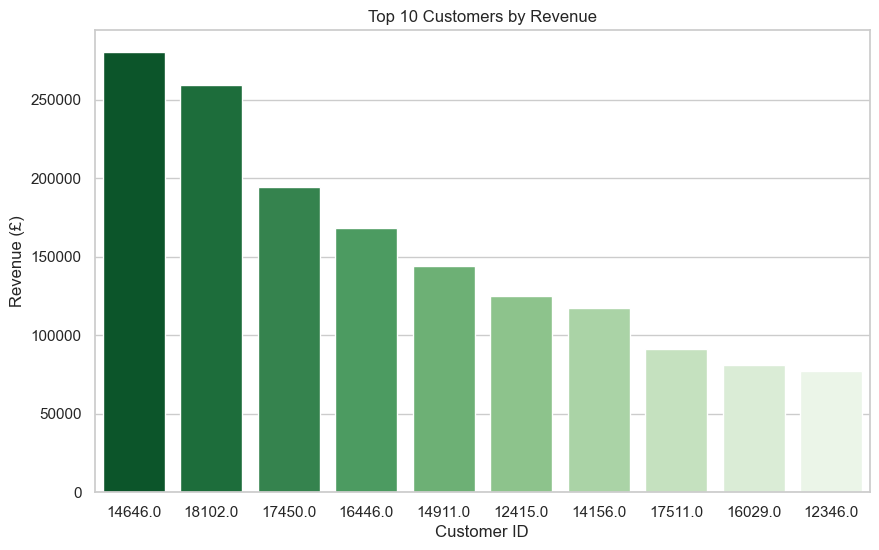

In [31]:
# 8.3 Top 10 Customers by Revenue
top_customers = df.groupby('CustomerID')['order_value'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_customers.index.astype(str), 
    y=top_customers.values, 
    hue=top_customers.index.astype(str), 
    palette="Greens_r", 
    dodge=False, 
    legend=False
)
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Revenue (£)")
plt.show()


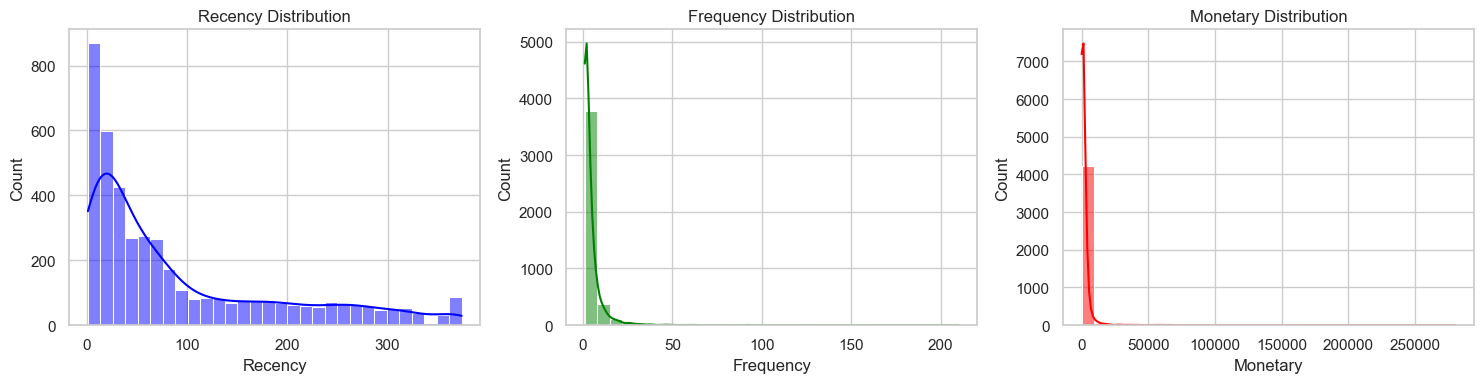

In [28]:
# 8.4 RFM Distributions
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30, kde=True, color="blue")
plt.title("Recency Distribution")

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30, kde=True, color="green")
plt.title("Frequency Distribution")

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30, kde=True, color="red")
plt.title("Monetary Distribution")

plt.tight_layout()
plt.show()


In [33]:
# Step 9: Insights

print("✅ Total Revenue: £", round(df['order_value'].sum(),2))
print("✅ Number of Unique Customers:", df['CustomerID'].nunique())
print("✅ Top Customer ID:", rfm.sort_values('Monetary', ascending=False).iloc[0]['CustomerID'])
print("✅ Top Product:", df.groupby('Description')['order_value'].sum().idxmax())


✅ Total Revenue: £ 8911407.9
✅ Number of Unique Customers: 4339
✅ Top Customer ID: 14646.0
✅ Top Product: PAPER CRAFT , LITTLE BIRDIE
